# **SBrT 2024 - An Introduction to Generative Artificial Intelligence with Applications in Telecommunications**

## Bisecting K-Means in RAG for Enhancing Question-Answering Tasks Performance in Telecommunications

This python notebook was based on the code at https://github.com/SuLLMerica/SuLLMerica/, that comes from the paper of same name, recently accepted on Globecom 2024 as a workshop paper.


The objective of this notebook is to show the most important parts of the RAG framework (and some recent additions) considering the Telecom domain of knowledge.

## Importing documents and dependencies from original repository

In [ ]:
!git clone https://github.com/SuLLMerica/SuLLMerica.git
!pip install -r /content/SuLLMerica/requirements.txt

Cloning into 'SuLLMerica'...
remote: Enumerating objects: 617, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 617 (delta 3), reused 7 (delta 2), pack-reused 606 (from 1)
Receiving objects: 100% (617/617), 847.28 MiB | 40.31 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Updating files: 100% (592/592), done.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.3 MB/s eta 0:00:00
Reason for being yanked: The Windows wheels, under some conditions, caused

## Importing Libraries

In [ ]:
import re
import os
import traceback
import sqlite3
import torch
import pandas as pd
import ujson as json
import torch.nn as nn
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

os.chdir("/content/SuLLMerica")

from Source.query import Query
from Source.maneger_dataset import get_embeddings_by_labels
from Source.generate_question import generate_questions_training
from Source.enhancement_query import EnhancementQuery
from Source.get_RAG_context import Get_RAG_Context

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

## Defining the Hyperparemeters and files to be used

The Database file can be found in [Kaggle](https://www.kaggle.com/datasets/frankmorte/sullmerica-data?resource=download&select=cluster_data_BisectingKMeans_18_250_chunksize.db), and the used model can be found on [HuggingFace](https://huggingface.co/SuLLMerica/TeleQnA-Phi2-Phinetune). There are several hyperparameters for this application, but here are the ones with most impact on the final accuracy.

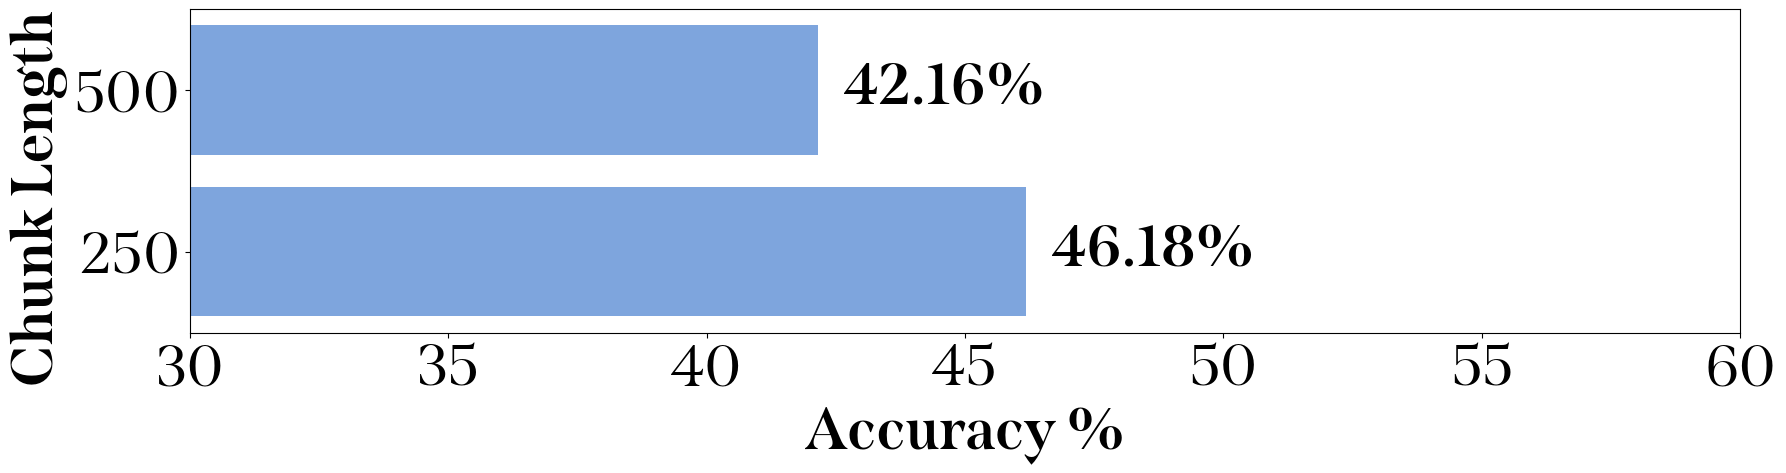

In [ ]:
PUBLIC_TEST = False

TEST_FILES=[
    "./Data/test/questions_new.txt",
    "./Data/test/TeleQnA_testing1.txt"
] if not PUBLIC_TEST else ["./Data/test/TeleQnA_testing1.txt"]

NUM_CLUSTERS = 18
TOP_K_CLUSTERS = 8
TOP_K_CHUNKS = 5
DATABASE_PATH="cluster_data_BisectingKMeans_18_250_chunksize.db"
TEST_FULL_DATASET = "./Data/TeleQnA_Dataset_Full.txt"
TEST_DATA_WITH_RAG_PATH = "./Data/intermediates/TeleQnA_Test_With_RAG_Context.json"
PATH_TERMS_FILE = "./Data/TermsAndDefinitions/terms_definitions.json"
PATH_ABBREVIATIONS_FILE = "./Data/TermsAndDefinitions/abbreviations_definitions.json"
MODEL_NAME = "claudiomello/Phi-2-TeleQnA-Finetune-Final"

## Adjusting Acronyms and Abbreviations

It's important to set a correct order of informations in the prompt, in order to direct the LLM to the correct anser. In this scenario, informations such as acronyms and abberviations, much used in the telecommunications domain, make it difficult for a NLP model accurately understand what is being requested by the user. In this sense, the final prompt given to the model also has some sort of glossary referred to the terms used in the query.

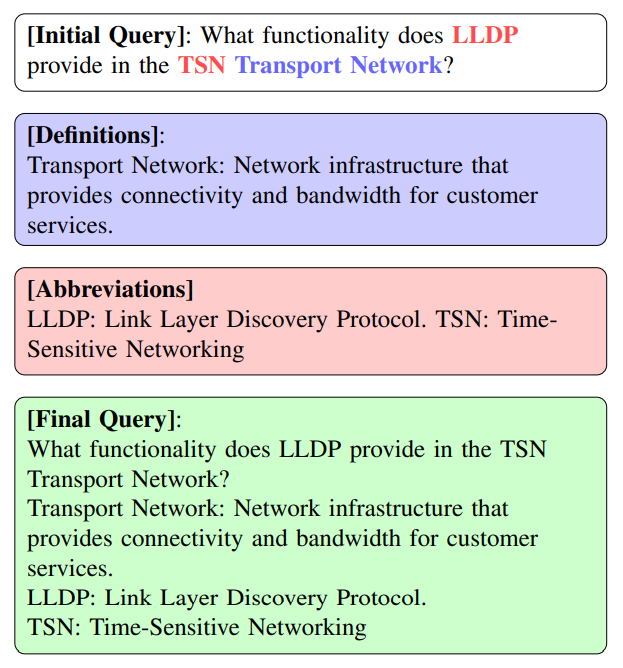

In [ ]:
class EnhancementQuery():
  def __init__(self,file_name_terms, file_name_abbreviations):
    with open (file_name_terms, "r") as file:  self.terms_definitions = json.load(file)
    with open (file_name_abbreviations, "r") as file:  self.abbreviations_definitions = json.load(file)

  def preprocess(self, sentence,lowercase=True):
    """Converts text and optionally converts to lowercase. Removes punctuation."""
    if lowercase:
        sentence = sentence.lower()
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for char in punctuations:
        sentence = sentence.replace(char, '')
    return sentence

  def find_and_filter_terms(self,terms_dict, sentence):

    """Finds terms in the given sentence, case-insensitively, and filters out shorter overlapping terms."""
    ## Preprocess the text input
    lowercase_sentence = self.preprocess(sentence, lowercase=True)

    # Find all terms
    matched_terms = {term: terms_dict[term] for term in terms_dict if self.preprocess(term) in lowercase_sentence}

    # Filter out terms that are subsets of longer terms
    final_terms = {}
    for term in matched_terms:
        if not any(term in other and term != other for other in matched_terms):
            final_terms[term] = matched_terms[term]

    return final_terms

  def find_and_filter_abbreviations(self, abbreviations_dict, sentence):
    """Finds abbreviations in the given sentence, case-sensitively, and filters out shorter overlapping abbreviations."""
    processed_sentence = self.preprocess(sentence, lowercase=False)
    words = processed_sentence.split()

    # Filter all abbreviations that make match in a dictionary
    matched_abbreviations = {word: abbreviations_dict[word] for word in words if word in abbreviations_dict}

    final_abbreviations = {}
    sorted_abbrs = sorted(matched_abbreviations, key=len, reverse=True)

    for abbr in sorted_abbrs:
        if not any(abbr in other and abbr != other for other in sorted_abbrs):
            final_abbreviations[abbr] = matched_abbreviations[abbr]

    return final_abbreviations

  def find_terms_and_abbreviations_in_sentence(self,terms_dict, abbreviations_dict, sentence):
    """Finds and filters terms or abbreviations in the given sentence.
       Abbreviations are matched case-sensitively, terms case-insensitively, and longer terms are prioritized."""
    processed_sentence = self.preprocess(sentence, lowercase=False)  # Preserve case for abbreviations

    matched_abbreviations = {abbr: abbreviations_dict[abbr] for abbr in abbreviations_dict if abbr in processed_sentence}

    # Find and filter terms
    matched_terms = self.find_and_filter_terms(terms_dict, sentence)

    # Format matched terms and abbreviations for output
    formatted_terms = [f"{term}: {definition}" for term, definition in matched_terms.items()]
    formatted_abbreviations = [f"{abbr}: {definition}" for abbr, definition in matched_abbreviations.items()]

    return formatted_terms, formatted_abbreviations

  def define_TA_question(self, sentence):

    sentence = sentence[0:sentence.find("[")]

    formatted_terms, formatted_abbreviations = self.find_terms_and_abbreviations_in_sentence(self.terms_definitions,
                                                                                        self.abbreviations_definitions,
                                                                                       sentence)
    if len(formatted_terms) !=0:
      terms= '\n'.join(formatted_terms)
    else:
      terms = None

    if len(formatted_abbreviations)!=0:

      abbreviations= '\n'.join(formatted_abbreviations)
    else:
      abbreviations=None

    return [terms,abbreviations]

In [ ]:
# Create an empty dictionary
test_data = {}

# Read both files and concatenate data
for file in TEST_FILES:
    with open(file) as f:
        test_data.update(json.load(f))

if PUBLIC_TEST:
    full_data = {}
    with open(TEST_FULL_DATASET) as f:
        full_data.update(json.load(f))

# Create a class for enhancement
enhacenment_query = EnhancementQuery(file_name_terms=PATH_TERMS_FILE, file_name_abbreviations=PATH_ABBREVIATIONS_FILE)

# Create an array to store the data
test_data_json = []

# Iterate over the test data for adding the terms and abbreviations
for question in test_data.keys():
    question_id = int(question.split(" ")[1])

    if PUBLIC_TEST:
        try:
            pub_answer = full_data[question]["answer"]
            pub_answer = int(pub_answer[7:8])
        except:
            pub_answer = -2
            print(f"Error in question {question} when trying to get the public answer")

    terms, abreviations = enhacenment_query.define_TA_question(test_data[question]["question"])

    data = {
        "question": test_data[question]["question"],
        "question_id": question_id,
        "terms": terms,
        "abbreviations": abreviations,
        "answer": pub_answer if PUBLIC_TEST else None
    }
    if "option 1" in test_data[question]:
        data["option 1"] = test_data[question]["option 1"]
    if "option 2" in test_data[question]:
        data["option 2"] = test_data[question]["option 2"]
    if "option 3" in test_data[question]:
        data["option 3"] = test_data[question]["option 3"]
    if "option 4" in test_data[question]:
        data["option 4"] = test_data[question]["option 4"]
    if "option 5" in test_data[question]:
        data["option 5"] = test_data[question]["option 5"]
    test_data_json.append(data)

## Bisecting K-Means for RAG in 3GPP Documents (the overall process)

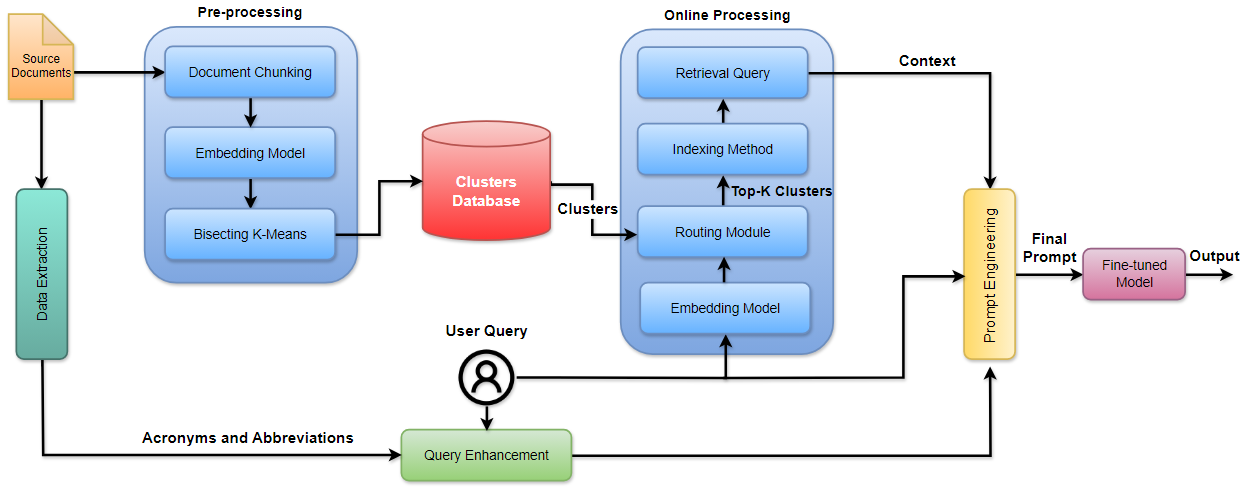

The processing is divided in two steps:

1. **The Pre-processing phase**
2. **The Online processing phase**

The main difference is that the pre-processing phase is only processed one time and the online phase is repeated every new user's query.

During the pre-processing phase, there are several steps:

*   **Acronyms and Abbreviations**: Enhance query with a glossary to make LLM have a better understanding of user's query.
*   **Document Chunking**: The big documents are split in small exerpts to be later stored and possibly retrieved in the future.
*   **Embedding Model**: This model converts every chunk into a collection of multidimensional vectors, where mathematical operations can be made to measure the "closeness"of a document to another.
*   **Bisecting K-Means**: The clustering algorithm allows the embedding space to be segmented into regions of same subject. It is a great addition, since it will make the searches in this space more efficiently.

The clusters created by the Bisecting K-Means algorithm will be stored in database file, called **Clusters Database**. The embedding will be taken from there to the next phase. In the second step, there is:

*   **User Query**: It is the question or demand of an user to the LLM's prompt.
*   **Embedding Model**: This model is used agai to convert the query into vectors and allow comparisons between the documents in the database and user's demands.
*   **Routing Module**: This element is a neural network which function is to determine which clusters are most related to query. This is a essencial steps in terms of computation cost, since it allows the search for embeddings in just a subset of all clusters.
*   **Indexing Method**: From the subset of clusters estimated, this entity is responsible for determine what are the the embeddings there are more related to query. The output is a list of index the original chunks related to the selected embeddings.
*   **Retrieval QUery**: In this step, the chunks related to query are retrieved in a string format and ordered from the most relevant to the query to least relevant, and directed to the LLM.

The collection of chunks related to the query is called **context**. Before asking the LLM for an answer to the query, a prompting engineering process is used to add the acronyms and abbreviations, the the context and the original query to the original prompt. This prompt is given as input to  fine-tuned LLM (a LLM adapted to this specific task) and then comes the answer.

In [ ]:
# Create a progress bar
pb = tqdm(
    test_data_json,
    total=len(test_data_json),
    desc="Generating RAG Contexts",
    unit="question",
)

# Create a list to store the questions
test_data_json_with_context=[]

# Connect to the SQLite database
conn = sqlite3.connect(DATABASE_PATH)


# Iterate over the questions for generating the RAG context
for question_data in pb:

    # Get the question
    question = question_data["question"]

    # Get the options
    options = {}
    try:
        option_1 = str(question_data["option 1"])
        if option_1 != "nan" and option_1 != "":
            options["option 1"] = option_1
    except KeyError:
        pass
    try:
        option_2 = str(question_data["option 2"])
        if option_2 != "nan" and option_2 != "":
            options["option 2"] = option_2
    except KeyError:
        pass

    try:
        option_3 = str(question_data["option 3"])
        if option_3 != "nan" and option_3 != "":
            options["option 3"] = option_3
    except KeyError:
        pass

    try:
        option_4 = str(question_data["option 4"])
        if option_4 != "nan" and option_4 != "":
            options["option 4"] = option_4
    except KeyError:
        pass

    try:
        option_5 = str(question_data["option 5"])
        if option_5 != "nan" and option_5 != "":
            options["option 5"] = option_5
    except KeyError:
        pass


    # Get the terms and abbreviations
    terms = None
    if str(question_data["terms"]) != "nan" and question_data["terms"] != "":
        terms = question_data["terms"]

    abbreviations = None
    if str(question_data["abbreviations"]) != "nan" and question_data["abbreviations"] != "":
        abbreviations = question_data["abbreviations"]

    # Generate the RAG context
    try:
        context = Get_RAG_Context(question, conn, NUM_CLUSTERS, TOP_K_CLUSTERS, TOP_K_CHUNCKS)
    except Exception as e:
        print(f"An error occurred: {e}")
        print(traceback.format_exc())

    test_data_json_with_context.append({
        "question": question,
        "Question_ID": question_data["question_id"],
        "options": options,
        "terms": terms,
        "abbreviations": abbreviations,
        "context": context,
        "answer": question_data["answer"] if PUBLIC_TEST else None
    })

# Close the connection to the database
conn.close()

Generating RAG Contexts:   0%|          | 0/2366 [00:00<?, ?question/s]


An error occurred: name 'TOP_K_CHUNCKS' is not defined
Traceback (most recent call last):
  File "<ipython-input-5-e22581cc1372>", line 70, in <cell line: 17>
    context = Get_RAG_Context(question, conn, NUM_CLUSTERS, TOP_K_CLUSTERS, TOP_K_CHUNCKS)
NameError: name 'TOP_K_CHUNCKS' is not defined



NameError: name 'context' is not defined

## The Routing Module

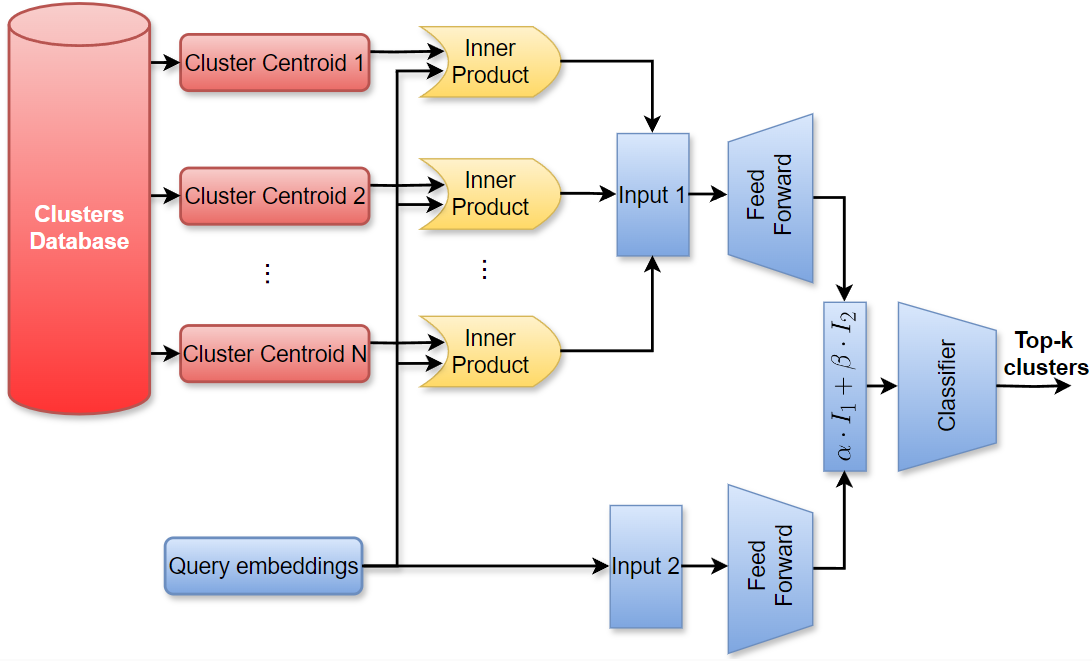

In [ ]:
class GaussianInitialized(nn.Module):
    def __init__(self, in_features, out_features, mean, std):
        super(GaussianInitialized, self).__init__()
        self.mean = mean
        self.std = std
        self.w = torch.normal(self.mean, self.std, size=(in_features, out_features))

    def forward(self):
        return self.w


class CustomModel(nn.Module):
    def __init__(self, num_cluster, random_state=None):
        super(CustomModel, self).__init__()
        np.random.seed(random_state)
        self.device = torch.device("cuda")
        # self.layer1_1 = nn.Linear(1024, 256)
        self.layer1_1 = GaussianInitialized(1024, 256, mean=0, std=3)
        self.dropout1 = nn.Dropout(0.1)

        # self.layer2_1 = nn.Linear(num_cluster, 256)
        self.layer2_1 = GaussianInitialized(num_cluster, 256, mean=0, std=3).to(
            self.device
        )
        self.dropout2 = nn.Dropout(0.05)

        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(256)

        self.alfa = nn.Parameter(torch.ones(1), requires_grad=True)
        self.beta = nn.Parameter(torch.ones(1), requires_grad=True)

        self.output_layer1 = nn.Linear(256, 128)
        self.output_layer2 = nn.Linear(128, num_cluster)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_1, input_2):

        x1 = torch.matmul(input_1, self.layer1_1().to(self.device))
        x1 = self.dropout1(x1)
        x1 = self.batchnorm1(x1)

        x2 = torch.matmul(input_2, self.layer2_1().to(self.device))
        x2 = self.dropout2(x2)
        x2 = self.batchnorm2(x2)

        weighted_x1 = self.alfa * x1
        weighted_x2 = self.beta * x2

        combined = weighted_x1 + weighted_x2

        output = self.output_layer1(combined)
        output = self.output_layer2(output)
        output = self.softmax(output)

        return output

## Testing the framework with some questions

In [ ]:
with open(TEST_DATA_WITH_RAG_PATH, "r") as file:
    test_data_json_with_context = json.load(file)

if PUBLIC_TEST:
    aux = []
    for question in test_data_json_with_context:
        question_id = question["Question_ID"]
        if int(question_id) < 10000:
            question["answer"] = full_data[f"question {question_id}"]["answer"]
            aux.append(question)
    test_data_json_with_context = aux

## Final Prompt Composition

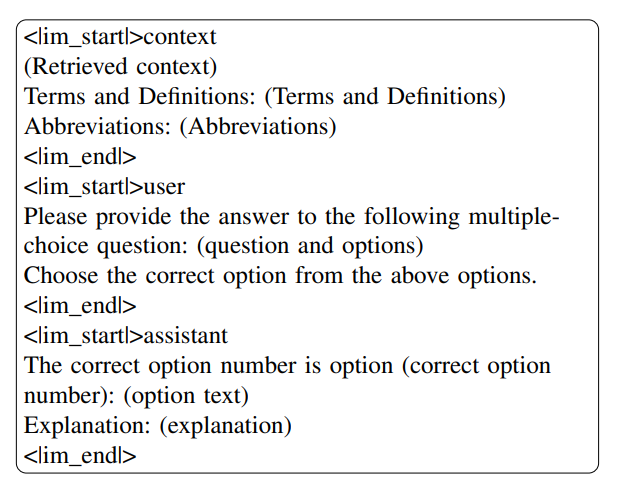

In [ ]:
# Set the torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.to(device)

answer_results = []

if PUBLIC_TEST:
    correct_answers = 0
    total_answers = 0

failed = 0

pb = tqdm(test_data_json_with_context, desc="Generating test answers", total=len(test_data_json_with_context), unit="Question")

# Iterate over the rows of the DataFrame
for question_iter in pb:
    # Get the question and answer
    question = str(question_iter["question"])

    try:
        option_1 = str(question_iter["options"]["option 1"])
        option_1_exists = True
    except KeyError:
        option_1 = ""
        option_1_exists = False
    try:
        option_2 = str(question_iter["options"]["option 2"])
        option_2_exists = True
    except KeyError:
        option_2 = ""
        option_2_exists = False
    try:
        option_3 = str(question_iter["options"]["option 3"])
        option_3_exists = True
    except KeyError:
        option_3 = ""
        option_3_exists = False
    try:
        option_4 = str(question_iter["options"]["option 4"])
        option_4_exists = True
    except KeyError:
        option_4 = ""
        option_4_exists = False
     try:
        option_5 = str(question_iter["options"]["option 5"])
        option_5_exists = True
    except KeyError:
        option_5_exists = False
        option_5 = ""

    # Update the question and answer in the DataFrame
    merged_question = (
        (
            question
            + "\n"
            + ("\n1. " + option_1 if option_1_exists else "")
            + ("\n2. " + option_2 if option_2_exists else "")
            + ("\n3. " + option_3 if option_3_exists else "")
            + ("\n4. " + option_4 if option_4_exists else "")
            + ("\n5. " + option_5 if option_5_exists else "")
        )
        + "\n\n"
        + "Choose the correct option from the above options"
    )
    context = ""
    for ret in question_iter["context"]:
        context += ret

    full_context = (
        f"Considering the following context:\n{str(context)}\n"
        + (
            f"Terms and Definitions:\n{question_iter['terms']}\n"
            if question_iter["terms"]
            else ""
        )
        + (
            f"Abbreviations: {question_iter['abbreviations']}\n"
            if question_iter["abbreviations"]
            else ""
        )
    )

    full_question = (
        f"Please provide the answer to the the following multiple choice question:\n{merged_question}\n"
        + "Write only the option number corresponding to the correct answer._"
    )

    input_tensor = tokenizer.apply_chat_template(
        [
            {
                "role": "context",
                "content": full_context,
            },
            {
                "role": "user",
                "content": full_question,
            }
        ],
        return_tensors="pt",
    )

    # Generate the answer
    with torch.no_grad():
        output = model.generate(
            input_tensor.to(device),
            max_length=2048,
            num_return_sequences=1,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Decode the answer
    response = tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract the answer from the full answer
    match = re.search(r"The correct option number is option (\d)", response)

    if match:
        answer = match.group(1)
    else:
        failed += 1
        pb.set_postfix({"Failed": failed})
        answer = -1

     try:
        answer = int(answer)
    except ValueError:
        failed += 1
        answer = -1
        pb.set_postfix({"Failed": failed})

    if PUBLIC_TEST:
        total_answers += 1
        if answer == question_iter["answer"]:
            correct_answers += 1
        pb.set_postfix({"Correct": correct_answers, "Total": total_answers, "Accuracy": correct_answers/total_answers})

    # Update the DataFrame
    answer_results.append(
        {
            "Question_ID": question_iter["Question_ID"],
            "Answer_ID": answer,
            "Task": "Phi-2",
            "Correct_Answer": question_iter["answer"] if PUBLIC_TEST else None
        }
    )

df = pd.DataFrame(answer_results)

if not PUBLIC_TEST:
    df.drop(columns=["Correct_Answer"], inplace=True)

## Getting results

In [ ]:
print(f"Accuracy: {correct_answers/total_answers}, Correct: {correct_answers}, Total: {total_answers}")
df
df.to_csv("./Data/results/test_results.csv", index=False)

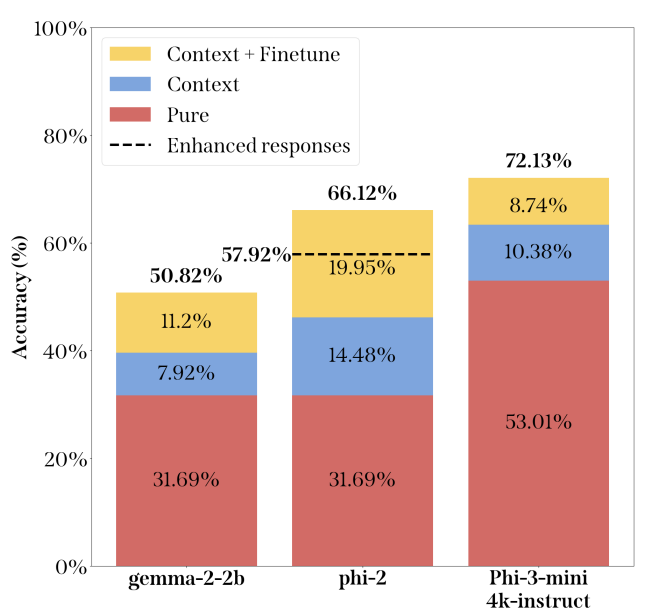